# Project: ML - RFR, GBR, KNN, MultivariateLR (Predict House Sale Prices)

<br>

## Problem:
- Predict house prices from data on house properties: Overall Qual, Gr Liv Area, Garage Area, Age, TotRms AbvGrd, etc)
- Regression using RandomForestRegressor, GradientBoostingRegressor, multivariate LinearRegression and KNN

<br>

## Tools:

- Feature Preparation, Selection and Engineering
  - transforming and processing:
    - drop leaky columns
    - HMD: remove columns with more than 25% missing values + inputation
    - combine some features into new ones
    - Categorical features
      - transform numerical to categorical (for those where numbers have no meaning)
      - identify text columns to make categorical:
        - only those with only a few unique values
        - remove low varianve columns (more than 95% of the values are the same)      
      - deal with NaNs, then dummy code       
  - selection: heatmap, SelectKBest & RFECV
- Models: KNN (algorithm = auto, p = 2), Multivariate LR with Ordinary Least Squares coded direcly  
- Model validation and hyperparameter search: GriSearchCV + K-fold validation and predictions
  -  bias versus variance on different number of Kfolds in cross validation for KNN model
  - holdout validation manually coded for Ordinary Least Squares manually coded
- Error Metrics: R^2, explained variance and RMSE

<br>

### load defaults

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})
plt.rcParams.update({'xtick.direction': 'in', 'ytick.direction': 'in'})
plt.rcParams.update({'xtick.top': 'on', 'ytick.right': 'on'})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.feature_selection import SelectKBest, f_regression, RFECV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, GridSearchCV

print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: House properties and price

In [2]:
df = pd.read_csv('./data/AmesHousing.txt', delimiter='\t')
display(df.iloc[:3,[0,1,2,3,4,5,6,7,8,9,10,11,12,-1]])

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,172000


<br>

## 1 -  Feature Engineering 
- drop columns that leak information about target column
- remove columns with more than 25% missing values
- replace NaNs with mean from other rows
- combine some features into new ones
- dummy coding for categorical features
  - transform numerical to categorical (for those where numbers have no meaning)
  - identify text columns to make categorical:
    - only those with only a few unique values
    - remove low varianve columns (more than 95% of the values are the same)      
  - deal with NaNs, then dummy code  

In [3]:
def transform_features(df):
    df_clean = df.copy()
    
    #remove columns that leak information about target  + PID
    to_drop = ['PID','Order', 'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition']
    df_clean.drop(to_drop,axis=1, inplace=True)
    
    #drop cols with more than 25% NaNs
    null_count = df.isnull().sum()
    null_cols = null_count[null_count>0.25*len(df_clean)].index 
    df_clean.drop(null_cols,axis=1, inplace=True)
    
    #replace NaNs in numeric null columns with mean
    null_count = df_clean.isnull().sum()
    null_cols = null_count[null_count>0].index    
    float_cols = df_clean.select_dtypes(include=['float']).columns
    df_clean[float_cols] = df_clean[float_cols].fillna(df_clean[float_cols].mean())
            
    #create new columns age and age since remodulation
    df_clean['Age'] = 2017 - df_clean['Year Built']
    df_clean['Age Since Remod'] = 2017 - df_clean['Year Remod/Add']
    df_clean['Remod Age'] = df_clean['Year Remod/Add'] - df_clean['Year Built']
    df_clean['GarageAge'] = 2017 - df_clean['Garage Yr Blt']
    df_clean.drop(['Year Built', 'Year Remod/Add', 'Garage Yr Blt'],axis=1, inplace=True)    
            
    #TRANSFORM TO CATEGORIC    
    #Identify numerical columns that should be categoric or transformed     
    #text_cols = df_clean.select_dtypes(include=['int64','float64']).columns
    #for col in text_cols:
    #    print(col)
    #    print(df_clean[col].iloc[0:9])
    
    #change numeric to str to make categorical
    df_clean['MS SubClass'] = df_clean['MS SubClass'].astype(str)          
     
    ###Identify text columns to make categorical 
    text_cols = df_clean.select_dtypes(include=['object']).columns
    for col in text_cols:           
        #drop large number of categories >10
        if(len(df_clean[col].unique())>10):
            df_clean.drop(col,axis=1, inplace=True)
        else:
            #drop low variance (more than 95% in one cat)
            counts = df_clean[col].value_counts()
            if(counts[0]>0.95*len(df_clean[col])):
                df_clean.drop(col,axis=1, inplace=True)  
            
    #Deal with remaining text nulls before dummy coding    
    null_count = df_clean.isnull().sum()
    null_cols = null_count[null_count>0].index   
    #print(df_clean[null_cols].info()) 
    #basement and garage descriptions have nulls(for houses without either)
    #large number of Nans in garage conditions and probably little influence on price: drop 
    garage_cols_to_drop = ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']
    df_clean.drop(garage_cols_to_drop,axis=1, inplace=True)
    #drop reamining nulls (basement condition rows)
    df_clean.dropna(axis=0, inplace=True)
              
    #DUMMY CODING    
    text_cols = df_clean.select_dtypes(include=['object']).columns    
    for col in text_cols:             
        df_clean[col] = df_clean[col].astype('category')   
        dummy_cols = pd.get_dummies(df_clean[col])    
        df_clean = pd.concat([df_clean, dummy_cols], axis=1)
        df_clean.drop(col, inplace=True, axis=1)  
              
    
    return df_clean

<br>

## 2 - feature selection
- manual process:
  - ignore categoric columns for now
  - calculate correlations and select strongly correlated
  - generate sns.heatmap to check any correlations between variables
- automated process:
  - using SelectKBest

### 2.1 - Feature Selection with .corr() & Heatmap

['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', '1st Flr SF', 'Total Bsmt SF', 'Full Bath', 'Age', 'Age Since Remod', 'GarageAge', 'Mas Vnr Area', 'TotRms AbvGrd']
SalePrice          1.000000
Overall Qual       0.796835
Gr Liv Area        0.710544
Garage Cars        0.650806
Garage Area        0.640152
1st Flr SF         0.634436
Total Bsmt SF      0.634317
Full Bath          0.555083
Age                0.554400
Age Since Remod    0.525825
GarageAge          0.511855
Mas Vnr Area       0.506103
TotRms AbvGrd      0.505792
Name: SalePrice, dtype: float64


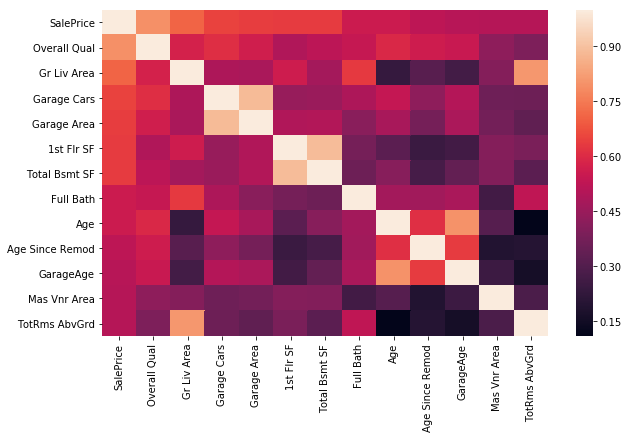

In [4]:
df_clean = transform_features(df)

#ignore categorical columns for now ('uint8')
num_cols = df_clean.select_dtypes(include=['int64','float64']).columns  

corrmat = df_clean[num_cols].corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values(ascending=False)
strong_corrs = sorted_corrs[sorted_corrs>0.5].index.tolist()
print(strong_corrs)
print(sorted_corrs[sorted_corrs>0.5])

plt.figure(figsize=(10,6))
sns.heatmap(df_clean[strong_corrs].corr().abs())
plt.show()

**There are some strongly correlations among the variables strongly correlated with SalePrice, choose the ones with highest correlation to sale price**
- 'Garage Cars' and 'Garage Area': Garage Cars
- '1st Flr SF' and 'Total Bsmt SF': 1st Flr SF
- 'Age', and 'GarageAge': Age

In [5]:
selected_features_manual = ['Overall Qual', 'Gr Liv Area', 'Garage Cars', '1st Flr SF', 
                            'Full Bath', 'Age', 'Age Since Remod', 'Mas Vnr Area', 'TotRms AbvGrd']

<br>

### 2.2 - Feature selection with SelectKBest

In [6]:
df_clean = transform_features(df)

num_cols = df_clean.select_dtypes(include=['int64']).drop(['SalePrice'], axis = 1).columns 
X = df_clean[num_cols].values
Y = df_clean['SalePrice'].values

test = SelectKBest(score_func=f_regression, k=5)
fit = test.fit(X, Y)
print("selected features:")
print(num_cols[test.get_support()].tolist())
selected_features_Kbest = num_cols[test.get_support()].tolist()

# summarize scores
np.set_printoptions(precision=3)
print("\nfit scores")
print(fit.scores_)

selected features:
['Overall Qual', '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Age']

fit scores
[2.262e+02 4.905e+03 3.960e+01 1.900e+03 2.127e+02 4.159e+00 2.875e+03
 1.256e+03 2.314e+02 5.613e+01 2.470e+01 9.694e+02 7.973e+02 3.257e+02
 2.820e+02 5.097e+01 3.081e+00 3.742e+01 1.613e+01 4.861e-01 1.251e+03
 1.078e+03 1.833e+02]


<br>

### 2.3 - Feature selection with RFECV

In [13]:
def select_features(df, target, model):    
    #select numeric and drop NaNs
    df_new = df.select_dtypes([np.number]).dropna(axis=1)
  
    all_X = df_new.drop(target, axis=1)
    all_y = df_new[target]
    
    #cv is the number of folds
    selector = RFECV(model, cv=10)
    selector.fit(all_X, all_y)    
    optimized_columns = list(all_X.columns[selector.support_])
    
    print("Best Columns \n"+"-"*12+"\n{}\n".format(optimized_columns))
    
    return optimized_columns


target = 'SalePrice'

model=LinearRegression()
optimized_columns_LR = select_features(df_clean, target, model)

model = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_leaf=2)    
optimized_columns_RFR = select_features(df_clean, target, model)

model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=100,subsample=0.6,random_state=42)  
optimized_columns_GBR = select_features(df_clean, target, model)

Best Columns 
------------
['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Age', 'Age Since Remod', 'Remod Age', 'GarageAge', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RM', 'IR1', 'IR2', 'IR3', 'Reg', 'Bnk', 'HLS', 'Low', 'Lvl', 'Corner', 'CulDSac', 'FR2', 'FR3', 'Inside', 'Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn', '1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE', '1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer', 'SLvl', 'Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed', 'BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone', 'Ex', 

In [7]:
optimized_columns_LR = ['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Age', 'Age Since Remod', 'Remod Age', 'GarageAge', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RM', 'IR1', 'IR2', 'IR3', 'Reg', 'Bnk', 'HLS', 'Low', 'Lvl', 'Corner', 'CulDSac', 'FR2', 'FR3', 'Inside', 'Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn', '1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE', '1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer', 'SLvl', 'Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed', 'BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone', 'Ex', 'Fa', 'Gd', 'TA', 'Ex', 'Fa', 'Gd', 'Po', 'TA', 'BrkTil', 'CBlock', 'PConc', 'Stone', 'Wood', 'Ex', 'Fa', 'Gd', 'Po', 'TA', 'Ex', 'Fa', 'Gd', 'Po', 'TA', 'Av', 'Gd', 'Mn', 'No', 'ALQ', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf', 'ALQ', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf', 'Ex', 'Fa', 'Gd', 'Po', 'TA', 'N', 'Y', 'FuseA', 'FuseF', 'FuseP', 'Mix', 'SBrkr', 'Ex', 'Fa', 'Gd', 'Po', 'TA', 'Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sal', 'Sev', 'Typ', 'N', 'P', 'Y']

   
optimized_columns_RFR = ['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch', 'Age', 'Age Since Remod', 'Remod Age', 'GarageAge', 'RL', 'RM', 'IR1', 'Reg', 'Bnk', 'HLS', 'Low', 'Lvl', 'Corner', 'CulDSac', 'Inside', 'Norm', '1Fam', '1.5Fin', '1Story', '2Story', 'Gable', 'Hip', 'BrkFace', 'None', 'Stone', 'Ex', 'Gd', 'TA', 'Fa', 'Gd', 'TA', 'BrkTil', 'CBlock', 'PConc', 'Ex', 'Fa', 'Gd', 'TA', 'Fa', 'Gd', 'Av', 'Gd', 'Mn', 'No', 'ALQ', 'GLQ', 'Unf', 'Ex', 'Gd', 'TA', 'N', 'Y', 'SBrkr', 'Ex', 'Gd', 'TA', 'Typ', 'N', 'Y']


optimized_columns_GBR = ['Lot Area', 'Overall Qual', 'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Screen Porch', 'Age', 'Age Since Remod', 'RL', 'RM', 'Bnk', 'Ex', 'Y', 'Ex', 'TA']

## 3 - Model Selection with GridSearchCV

In [8]:
#from dask_ml.model_selection import GridSearchCV
#import os
#os.environ["JOBLIB_START_METHOD"] = "forkserver"
#os.environ['MKL_NUM_THREADS'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'
#os.environ['NUMEXPR_NUM_THREADS'] = '1'
#os.environ['JOBLIB_START_METHOD'] = 'fork'
#print(os.environ['JOBLIB_START_METHOD'])

#%env LOKY_PICKLER='cloudpickle' 
#import multiprocessing
#multiprocessing.set_start_method('forkserver', force=True)

from sklearn.utils import parallel_backend
import time

def select_model(df, target, models_to_fit):
    
    dicts= [ {
               "name": "LinearRegression",
               "estimator": LinearRegression(),
               "hyperparameters": 
                 {                
                   'fit_intercept':[True,False], 
                   'normalize':[True,False]            
                 }
             },
             {
               "name": "KNeighborsRegressor",
               "estimator": KNeighborsRegressor(),
               "hyperparameters": 
                 {
                   "n_neighbors": range(1,15,3),
                   "weights": ["distance", "uniform"],
                   "algorithm": ["ball_tree", "brute"],
                   "leaf_size": range(1,20,4),
                   "p": [1,2],
                   "metric":['manhattan','chebyshev','minkowski']                    
                 }
             },
             {
               "name": "RandomForestRegressor",
               "estimator": RandomForestRegressor(n_jobs=1, random_state=42),
               "hyperparameters": 
                 {
                   "n_estimators": [5, 20, 100],
                   #"n_estimators": [5],
                   "criterion": ["mse", "mae"],
                   "max_depth": [2, 5, 10],
                   "max_features": ["auto", "log2", "sqrt"],
                   "min_samples_leaf": [1, 5, 8],
                   "min_samples_split": [2, 3, 5]                
                 }
             }, 
             {
               "name": "GradientBoostingRegressor",
               "estimator": GradientBoostingRegressor(),
               "hyperparameters": 
                 {
                   "n_estimators": [5, 20, 100],  
                   "max_features": ["auto", "log2", "sqrt"],
                   "learning_rate":[0.01, 0.05, 0.1, 0.5],
                   "subsample":[0.1, 0.5, 1.0],  
                   "random_state":[1]     
                 }
             }]   
    scoring = {'Explained Variance': 'explained_variance', 'R2': 'r2', 'MSE':'neg_mean_squared_error'}
        
    all_y = df[target]
    
    for key, models_list in models_to_fit.items():        
        print(key)
        print('-'*len(key))
        start = time.time()
        for element in dicts:
            if models_list[0] == element['name']:                
                all_X = df[models_list[1]]              
                model = element['estimator']
                grid = GridSearchCV(model, element['hyperparameters'], cv=10, scoring=scoring, 
                                    refit='R2', iid=True, n_jobs=1)
                grid.fit(all_X, all_y)
        
                element['best_params'] = grid.best_params_
                element['best_score'] = grid.best_score_
                element['best_estimator'] = grid.best_estimator_          
                for scorer in scoring: 
                    if(scorer=='MSE'):
                        print(f"RMSE: {np.sqrt(-max(grid.cv_results_['mean_test_'+scorer])):0.3f}")
                    else:
                        print(f"{scorer}: {max(grid.cv_results_['mean_test_'+scorer]):0.3f}")
                print("Best Parameters: {}".format(grid.best_params_))
                print("Best Score: {:0.3f}\n".format(grid.best_score_))
        
        print(f"Time elapsed: {(time.time()-start)/60.:0.2f} mins\n\n")
        #for scorer in scoring:
        #    print(cv_results_'_<scorer_name>')
       
    return dicts
                              
#if __name__ == '__main__':
#    multiprocessing.set_start_method('forkserver')
#with parallel_backend('multiprocessing'):                         
df_clean = transform_features(df)                              
                   
models_to_fit = {'LinearRegression': ['LinearRegression', optimized_columns_LR],    
                 'KNeighborsRegressor': ['KNeighborsRegressor',optimized_columns_LR], 
                 'RandomForestRegressor_1': ['RandomForestRegressor', optimized_columns_RFR],
                 'RandomForestRegressor_2': ['RandomForestRegressor', selected_features_manual],
                 'GradientBoostingRegressor': ['GradientBoostingRegressor', optimized_columns_GBR]}
#models_to_fit = ['LinearRegression','RandomForestRegressor']                              
#optimized_columns = {'LinearRegression': optimized_columns_LR, 'RandomForestRegressor': optimized_columns_RFR}

target = 'SalePrice'
model_dicts = select_model(df_clean[:int(len(df_clean))], target, models_to_fit)
#1 - Time elapsed:114.45s
#4 - Time elapsed:

print("model selection finished")

LinearRegression
----------------
Explained Variance: 0.833
R2: 0.831
RMSE: 31846.750
Best Parameters: {'fit_intercept': True, 'normalize': False}
Best Score: 0.831

Time elapsed: 0.04 mins


KNeighborsRegressor
-------------------
Explained Variance: 0.747
R2: 0.739
RMSE: 38655.206
Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 5, 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Score: 0.739

Time elapsed: 346.67 mins


RandomForestRegressor_1
-----------------------
Explained Variance: 0.863
R2: 0.862
RMSE: 27906.751
Best Parameters: {'criterion': 'mae', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.862

Time elapsed: 275.60 mins


RandomForestRegressor_2
-----------------------
Explained Variance: 0.840
R2: 0.839
RMSE: 30174.959
Best Parameters: {'criterion': 'mae', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1

<br>

## 4 - Cross_Val Predictions for best models (RandomForest & GradientBoosting)

In [12]:
import time
start = time.time()
     
kf = KFold(10, shuffle=True, random_state=1)

best_model = {'criterion': 'mae', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 
              'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}
model = RandomForestRegressor()
model.set_params(**best_model)  
pred_1 = cross_val_predict(model, df_clean[optimized_columns_RFR], df_clean['SalePrice'], cv=kf, n_jobs=-1)

best_model = {'learning_rate': 0.1, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 1,
              'subsample': 0.5}
model = GradientBoostingRegressor()
model.set_params(**best_model)  
pred_2 = cross_val_predict(model, df_clean[optimized_columns_GBR], df_clean['SalePrice'], cv=kf, n_jobs=-1)

print(f"Time taken to build models: {time.time() - start:0.2f}s")

Time taken to build models: 86.24s


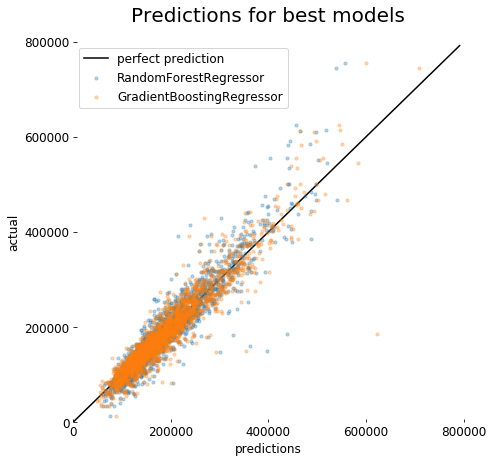

In [37]:
fig, ax = plt.subplots(figsize=(7,7))
lim = [0,800000]
ax.set_xlim(lim), ax.set_ylim(lim)

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
bin = int((xmax-xmin)/100)
ax.plot(np.arange(xmin, xmax, bin), np.arange(xmin, xmax, bin), c='k', label='perfect prediction', zorder=-1)

# Create a scatter plot with train and test actual vs predictions
ax.scatter(pred_1, df_clean['SalePrice'], alpha=0.3, label='RandomForestRegressor', marker='o', s=10)
ax.scatter(pred_2, df_clean['SalePrice'], alpha=0.3, label='GradientBoostingRegressor', marker='o', s=10)

for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)

ax.yaxis.set_major_locator(MultipleLocator(200000))    
ax.xaxis.set_major_locator(MultipleLocator(200000))    

plt.xlabel('predictions')
plt.ylabel('actual')
plt.title('Predictions for best models')
plt.legend()
plt.show()

<br>

## 5 - Cross Validation with different kfolds for KNN model:
- implement simple cross validation (holdout): train on a subset of the data and test on the rest
- implement k-fold cross valiation

In [206]:
def train_and_test(df, target, model, cv_type='simple'):  
    if(cv_type != 'kfold'):
        cv_type = 'simple'
       
    features = df.columns.drop(target)
    
    if(cv_type=='simple'): 
        split_1 = df[0:int(len(df)/2)].copy()
        split_2 = df[int(len(df)/2):].copy()
           
        model.fit(split_1[features], split_1[target])
        predictions = model.predict(split_2[features])
        rmse_1 = (np.sqrt(mean_squared_error(split_2[target],predictions)))
        
        model.fit(split_2[features], split_2[target])
        predictions = model.predict(split_1[features])
        rmse_2 = (np.sqrt(mean_squared_error(split_1[target],predictions)))
        
        print("RMSE on set_1 = {:0.2f} \nRMSE on set_2 = {:0.2f}".format(rmse_1, rmse_2))
        
        return predictions
    
    else:          
        rmse_mean_list=[]   
        rmse_std_list=[]     
        num_folds = np.linspace(5,2800,30).astype(int)         
        for fold in num_folds:
            kf = KFold(fold, shuffle=True, random_state=1)             
            mses = cross_val_score(model, df[features], df[target], scoring="neg_mean_squared_error", 
                                   cv=kf, n_jobs=-1) 
            rmses = np.sqrt(np.absolute(mses))
            rmse_mean_list.append(np.mean(rmses))   
            rmse_std_list.append(np.std(rmses))            
            
        print(f"Mean RMSE_Mean with cross_val: {np.mean(np.array(rmse_mean_list)):0.2f}")     
        print(f"Mean RMSE_Std with cross_val: {np.mean(np.array(rmse_std_list)):0.2f}")        
        error = np.sqrt(np.array(rmse_mean_list)**2+np.array(rmse_std_list)**2)
        print(f"Error with cross_val: {np.mean(error):0.2f}")
        
        #plot       
        fig, ax = plt.subplots(figsize=(5,5))
        ax.plot(num_folds, error)
        #ax.plot(num_folds, np.array(rmse_mean_list))
        #ax.plot(num_folds, np.array(rmse_std_list))
            
        folds_array = np.array(num_folds)        
                
        ax.set_xlabel('kfolds'), ax.set_ylabel('$\sqrt{bias^2+var^2}$')
        ax.tick_params(right=False, top=False)    
        ax.spines['right'].set_visible(False) 
        ax.spines['top'].set_visible(False) 
        plt.show()
        
        
        kf = KFold(10, shuffle=True, random_state=1)
        model = KNeighborsRegressor(n_neighbors = 5, algorithm = 'auto', p=2)
        predictions = cross_val_predict(model, df[features], df[target], cv=kf)
        
        return predictions     

<br>

**holdout and k-fold valiation**

Features used: ['Overall Qual', 'Gr Liv Area', 'Garage Cars', '1st Flr SF', 'Full Bath', 'Age', 'Age Since Remod', 'Mas Vnr Area', 'TotRms AbvGrd']

Simple Validation:
RMSE on set_1 = 45982.19 
RMSE on set_2 = 42457.62

K-fold Validation:
Mean RMSE_Mean with cross_val: 31468.73
Mean RMSE_Std with cross_val: 25223.37
Error with cross_val: 41074.00


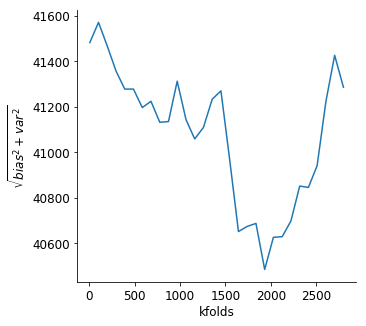

In [207]:
df_clean = transform_features(df)
target = 'SalePrice'
cols_to_keep = selected_features_manual
#cols_to_keep = selected_features_Kbest
#cols_to_keep = df.select_dtypes(include=['int64','float64']).columns  
#cols_to_keep = ['Age']    
   
print(f"Features used: {cols_to_keep}\n")

df_clean = df_clean[cols_to_keep+['SalePrice']]  
model = KNeighborsRegressor(n_neighbors = 5, algorithm = 'auto', p=2, n_jobs=-1)
    
print("Simple Validation:")
predictions = train_and_test(df_clean, target, model, cv_type='simple')

print("\nK-fold Validation:")
predictions = train_and_test(df_clean, target, model, cv_type='kfold')

<br>

## 6 - Holdout validation for Manually coded Linear Regression (OLS)

In [176]:
df_clean = transform_features(df)
target = 'SalePrice'
cols_to_keep = selected_features_manual
#cols_to_keep = selected_features_Kbest
#cols_to_keep = df.select_dtypes(include=['int64','float64']).columns  
#cols_to_keep = ['Age']    
   
print(f"Features used: {cols_to_keep}\n")

df_clean = df_clean[cols_to_keep+['SalePrice']]  

train = df_clean[0:int(len(df_clean)/2)].copy()
test = df_clean[int(len(df_clean)/2):].copy()

features = train.columns.drop('SalePrice')

X = train[features]
y = train['SalePrice']

a = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)), np.transpose(X)), y)
print(a)

train_predictions = train[features[0]]*a[0]
test_predictions = test[features[0]]*a[0]
for ii in range(1, len(a)):
    train_predictions += train[features[ii]]*a[ii]
    test_predictions += test[features[ii]]*a[ii]

target = 'SalePrice'
train_rmse = np.sqrt(np.abs(mean_squared_error(train[target], train_predictions)))
test_rmse = np.sqrt(np.abs(mean_squared_error(test[target], test_predictions)))

print("\nRMSE on training set = {:0.2f} \nRMSE on test set = {:0.2f}".format(train_rmse, test_rmse))

Features used: ['Overall Qual', 'Gr Liv Area', 'Garage Cars', '1st Flr SF', 'Full Bath', 'Age', 'Age Since Remod', 'Mas Vnr Area', 'TotRms AbvGrd']

[ 14807.258     59.379  10915.421     46.178 -16236.035   -433.853
   -528.279     38.066  -1935.261]

RMSE on training set = 32608.98 
RMSE on test set = 40447.77
